In [1]:
from datetime import datetime
from pathlib import Path
# Importamos todos los paquetes y módulos para entrenar el modelo
from PIL import Image
import imageio
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras import layers
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.utils import image_dataset_from_directory
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import exifread
import tensorflow as tf

2023-06-09 00:07:07.751680: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 00:07:08.507108: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
path = Path("./datos_tarea2") / "raw.tif"

In [3]:
path.exists()

True

In [4]:
f = open(path, 'rb')
# Return Exif tags
tags = exifread.process_file(f)

# Print the tag/ value pairs
for tag in tags.keys():
    if tag not in ('JPEGThumbnail', 'TIFFThumbnail', 'Filename', 'EXIF MakerNote'):
        print( "Key: %s, value %s" % (tag, tags[tag]))
        
f.close()

Key: Image SubfileType, value Full-resolution Image
Key: Image ImageWidth, value 512
Key: Image ImageLength, value 512
Key: Image BitsPerSample, value 8
Key: Image PhotometricInterpretation, value 1
Key: Image ImageDescription, value ImageJ=1.51h
images=55
slices=55
loop=false

Key: Image StripOffsets, value 7281
Key: Image SamplesPerPixel, value 1
Key: Image RowsPerStrip, value 512
Key: Image StripByteCounts, value 262144
Key: Image Tag 0xC696, value [12, 7058]
Key: Image Tag 0xC697, value []
Key: Thumbnail SubfileType, value Full-resolution Image
Key: Thumbnail ImageWidth, value 512
Key: Thumbnail ImageLength, value 512
Key: Thumbnail BitsPerSample, value 8
Key: Thumbnail PhotometricInterpretation, value 1
Key: Thumbnail ImageDescription, value ImageJ=1.51h
images=55
slices=55
loop=false

Key: Thumbnail StripOffsets, value 269425
Key: Thumbnail SamplesPerPixel, value 1
Key: Thumbnail RowsPerStrip, value 512
Key: Thumbnail StripByteCounts, value 262144
Key: IFD 2 SubfileType, value Fu

In [5]:
initializer = tf.keras.initializers.Ones()
values = initializer(shape=(3,3))/9

2023-06-09 00:07:12.482868: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [6]:
values

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111]], dtype=float32)>

In [7]:
from PIL import Image

#for img in imageio.imread(path):
#    print(img.shape)
image_array = imageio.imread(path).T
print(image_array.shape)

(512, 512, 55)


/tmp/ipykernel_327339/437082514.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_array = imageio.imread(path).T


In [8]:
tf.test.gpu_device_name() # Verificamos que Tensorflow está utilizando una GPU

''

In [9]:
image = tf.keras.preprocessing.image.load_img(path) # Importamos la imagen


In [10]:
image

In [11]:
kernel = np.array(
    [
     [1,1,1],
     [1,1,1],
     [1,1,1]
    ])

In [12]:
kernel_plain = np.expand_dims([kernel], axis=-1)

weights = [kernel_plain,np.array([0])]

In [13]:
kernel_plain

array([[[[1],
         [1],
         [1]],

        [[1],
         [1],
         [1]],

        [[1],
         [1],
         [1]]]])

In [14]:
weights

[array([[[[1],
          [1],
          [1]],
 
         [[1],
          [1],
          [1]],
 
         [[1],
          [1],
          [1]]]]),
 array([0])]

In [25]:
kernel = np.array(
    [
     [1,1,1],
     [1,1,1],
     [1,1,1]
    ])  
# se aplican tres capas de kernel, por las 3 capas de imagen
# con esto se crea un 'cubo'
def create_kernel3d(kernel, n=3):
    kernel = np.expand_dims(np.stack([kernel for _ in range(n)]), axis=-1)
    #kernel = np.expand_dims(np.stack([kernel]), axis=-1)
    weights = [kernel,np.array([0])]
    return weights

In [26]:
image_matrix = tf.keras.preprocessing.image.img_to_array(image) / 255 # Transformamos la imagen en un arreglo y lo normalizamos entre 0 y 1.
image_matrix.shape # Estas son las dimensiones de nuestra imagen (largo, ancho, canales)

(512, 512, 3)

In [27]:
def nice_image_printer(model, image):
    """prints the cat as a 2d array"""
    image_batch = np.expand_dims(image,axis=0)
    conv_image2 = model.predict(image_batch)
    
    conv_image2 = np.squeeze(conv_image2, axis=0)
    conv_image2 = conv_image2.reshape(conv_image2.shape[:2])

    plt.imshow(conv_image2 , cmap="copper")
    plt.colorbar()


In [37]:
def intensidad(img):
    n = 1
    if len(img.shape)==3:
        n = img.shape[2]
    print(f"n : {n}", img.shape)
    kernel = np.array(
        [
         [1,1,1],
         [1,1,1],
         [1,1,1]
        ]) / 9   
    weights = create_kernel3d(kernel, n)
    kernel_init = tf.keras.initializers.Ones() # genera tensor de 1, (matriz)
    model = tf.keras.Sequential([
      tf.keras.layers.Conv2D( # Capa convolucional
          filters = 1, # Sólo utilizaremos 1 kernel
          kernel_size = (3,3), # Estas son las dimensiones del kernel
          input_shape = img.shape, # Estas son las dimensiones de entrada de la red.
          weights = weights,
          kernel_initializer = kernel_init # Utilizamos un kernel Ones
      )
    ])
    print(img.shape)
    return nice_image_printer(model,img)

n : 3 (512, 512, 3)
(512, 512, 3)
1/1 [==============================] - 0s 30ms/step


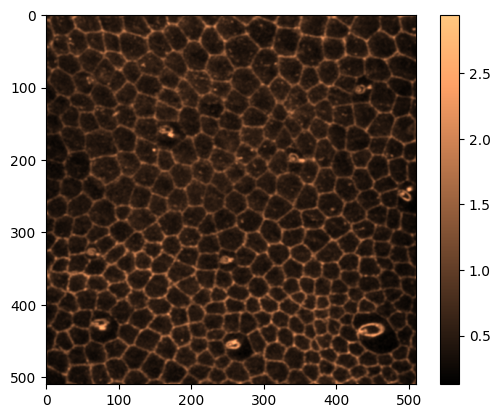

In [32]:
intensidad(image_matrix)

In [33]:
image_array.shape

(512, 512, 55)

In [36]:
image_array[:,:,1].shape

(512, 512)

In [45]:
new_image = []
for i in range(image_array.shape[2]):
    img = np.stack([image_array[:,:,i]])
    print(img.shape)
    ni = intensidad(img)
    new_image.append(ni)

(1, 512, 512)
n : 512 (1, 512, 512)


ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv2d_11. Consider increasing the input size. Received input shape [None, 1, 512, 512] which would produce output shape with a zero or negative value in a dimension.

In [22]:
def gradiente(img):
    model = tf.keras.Sequential([
      tf.keras.layers.Conv2D( # Capa convolucional
          filters = 1, # Sólo utilizaremos 1 kernel
          kernel_size = (3,3), # Estas son las dimensiones del kernel
          input_shape = img.shape, # Estas son las dimensiones de entrada de la red.
          kernel_initializer = kernel_init # Utilizamos un kernel gausiano que lo generamos con nuestro inicializador
      )
    ])
    return model.predict(img)

In [23]:
def laplaciano(img):
    pass

In [24]:
np.stack([kernel, kernel, kernel])

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]])

In [83]:
weights

[array([[[[1],
          [1],
          [1]],
 
         [[1],
          [1],
          [1]],
 
         [[1],
          [1],
          [1]]]]),
 array([0])]